In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt
from scipy import ndimage

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

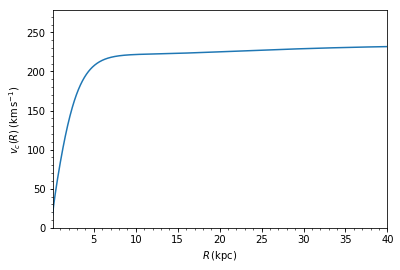

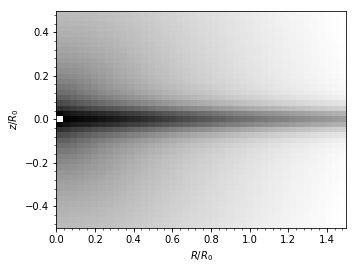

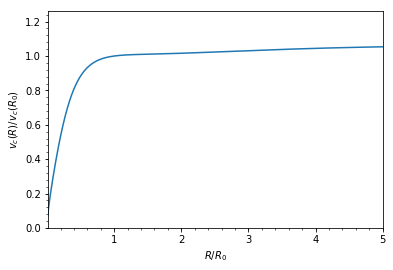

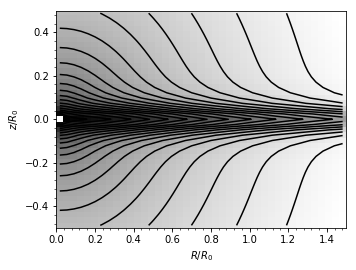

In [3]:
# galpy playtime


r0 = 8.
v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.4 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
#hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
   
mp.turn_physical_on()
nfwp.turn_physical_on()
#hep.turn_physical_on()
pot = [mp,nfwp] #,hep]

plotRotcurve(pot)
plotDensities(pot, log = True, nrs = 41, nzs = 41)


mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw))
   
pot2 = [mp,nfwp,hep]

plotRotcurve(pot2)
plotDensities(pot2, log = True, nrs = 41, nzs = 41)



In [4]:
R = np.arange(0.1, 25.1, 0.5)
#R = R/r0
z = np.arange(-12.5, 12.5, 0.5)
#z = z/r0
rho, rho2, r = np.zeros((len(z), len(R))), np.zeros((len(z), len(R))), np.zeros((len(z), len(R)))

for ii, zii in enumerate(z):
    for jj, Rjj in enumerate(R):
        rho[ii, jj] = evaluateDensities(pot, Rjj/r0, zii/r0)
        rho2[ii, jj] = evaluateDensities(pot2, Rjj/r0, zii/r0) * bovy_conversion.dens_in_msolpc3(v0,r0) #* 10.
        r[ii, jj] = np.sqrt(Rjj**2 + zii**2)

r = np.ravel(r)
print('rho 1 (potential initialized with r0/v0)\n')
print(rho)
print('\nrho 2 (potential initialized without r0/v0)\n')
print(rho2)
print('\ndifference between rho2 and rho1\n')
print(rho2-rho)


rho 1 (potential initialized with r0/v0)

[[ 0.00517208  0.00516331  0.00514216 ...,  0.00144773  0.0014042
   0.0013623 ]
 [ 0.00550074  0.00549073  0.00546658 ...,  0.00147113  0.00142625
   0.00138309]
 [ 0.00586179  0.0058503   0.00582259 ...,  0.00149428  0.00144804
   0.00140361]
 ..., 
 [ 0.00625984  0.00624658  0.00621461 ...,  0.00151711  0.00146951
   0.00142382]
 [ 0.00586179  0.0058503   0.00582259 ...,  0.00149428  0.00144804
   0.00140361]
 [ 0.00550074  0.00549073  0.00546658 ...,  0.00147113  0.00142625
   0.00138309]]

rho 2 (potential initialized without r0/v0)

[[ 0.00517208  0.00516331  0.00514216 ...,  0.00144773  0.0014042
   0.0013623 ]
 [ 0.00550074  0.00549073  0.00546658 ...,  0.00147113  0.00142625
   0.00138309]
 [ 0.00586179  0.0058503   0.00582259 ...,  0.00149428  0.00144804
   0.00140361]
 ..., 
 [ 0.00625984  0.00624658  0.00621461 ...,  0.00151711  0.00146951
   0.00142382]
 [ 0.00586179  0.0058503   0.00582259 ...,  0.00149428  0.00144804
   0.0014036

In [5]:
np.sum(np.isnan(rho))

0

Zu galpy Einheiten und so:
--

- evaluateDensities ist wohl immer in galpy units, also teile durch r0.
- wenn Potential schon mit r0 und z0 initialisiert wurde ist es bereits in physikalischen einheiten, auch der evaluateDensities output
- wenn nicht, muss man den Density output umwandeln mit * bovy_conversion.dens_in_msolpc3(v0,r0)



2.45736841577


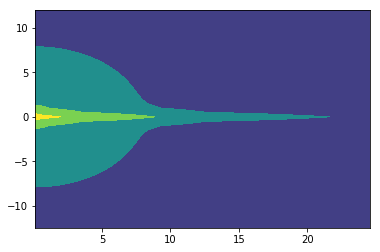

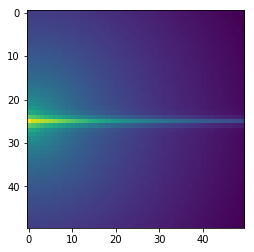

In [6]:
rho[np.isinf(rho)] = np.nanargmax(rho)
print(np.max(rho))
plt.contourf(R, z, rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))

plt.show()
plt.imshow(rho, norm=LogNorm(vmin=np.min(rho), vmax=np.max(rho)))


In [7]:
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, v0,\
                  R = None, z = None, r0 = None):    #a_he, n_he,
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    #n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    #hep = HEpot(a = a_he, normalize = n_he)
    
    pot = [mp, nfwp]#, hep]
    densi = np.zeros([len(z), len(R)])
    for ii, zjj in enumerate(z):
        for jj, Rii in enumerate(R):
            densi[ii, jj] = evaluateDensities(pot, Rii/r0, zjj/r0) #* bovy_conversion.dens_in_msolpc3(v0,r0) * 10.
    
    plt.contourf(R, z, densi, norm=LogNorm(vmin=np.min(densi), vmax=np.max(densi)))

    return densi



def RMS(x, R, z, N, rho, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, v0 = x[0], x[1], x[2], x[3], x[4], x[5]#, x[6], x[7] a_he, n_he
    ydata = rho
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw,  v0, R, z, r0) * bovy_conversion.dens_in_msolpc3(v0,r0) #a_he, n_he,
    RMS = np.sum((ydata - ymodel)**2/(ydata**2))
    print(x)
    print(RMS)
    print(n_mp + n_nfw)
    return RMS

a_mp = 0.4 #0.5 
b_mp = 0.1 #0.0375 
n_mp = 0.8 #0.6  
a_nfw = 3. #4.5 
n_nfw = 0.1 #0.35 
a_he = 6. # 0.6 / 8. 
n_he = 0.1 
v0 = 200. #220


'''v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
'''
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , v0) # a_he, n_he, 

bounds = ((1e-3, None), (1e-3, None), (1e-3, 0.999), (1e-3, None), (1e-3, 0.999), (1e-3, None)) # (1e-3, None), (1e-3, 0.999),n_he

r0 = 8.
N = len(R)

cons = ({'type': 'eq', 'fun': lambda x:  1. - (x[2] + x[4] )})
        
res = opt.minimize(RMS, x0 = x0, args= (R, z, N, rho, r0), bounds = bounds, constraints = cons)



In [10]:
res

     fun: 1.543068689078161e-07
     jac: array([  6.01669556e-03,  -1.38417533e-01,   6.41526622e-03,
        -2.29236744e-04,   4.82405953e-03,   5.17376352e-05])
 message: 'Optimization terminated successfully.'
    nfev: 331
     nit: 39
    njev: 38
  status: 0
 success: True
       x: array([  4.99997868e-01,   3.74987476e-02,   6.00006538e-01,
         4.49994115e+00,   3.99993462e-01,   2.20002350e+02])

In [11]:
a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
v0 = 220.